#  Лабораторная работа №2 
###### Приховування даних в просторової області нерухомих зображень методом блокового вбудовування, методом квантування та методом "хреста"

_по курсу: "Стеганография"_

_Кривич Максим, КБ-41_

_Харьков - 2017г._

In [1]:
%matplotlib inline
import os
import sys
import math
import time
import codecs
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

np.seterr(over='ignore') # Suppressing Overflow RuntimeWarnings

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [2]:
img_tamplate = 'images/img{}.bmp'
text_file = 'text.txt'
eol = '$$'

In [3]:
def np_2_image(array):
    try:
        return Image.fromarray(array)
    except:
        return None

In [4]:
def image_2_np(image):
    try:
        return np.array(image)
    except:
        return None

In [5]:
def open_image_2_np(filename):
    return image_2_np(Image.open(filename))

In [6]:
def read_text(filename):
    with codecs.open(filename, encoding='ascii', mode='r') as f:
        return f.read().strip()

In [7]:
def str_2_bin(*args):
    return ''.join(bin(ord(x))[2:].zfill(8) for x in ''.join(args))

In [8]:
def bin_2_str(binary, length=8):
    bin_l = [binary[i:i+length] for i in range(0, len(binary), length)]
    return ''.join([chr(int(c, 2)) for c in bin_l])

In [9]:
def chunks(l, n, step=4):
    for i in range(0, len(l) - n + 1, step):
        yield l[i:i + n]

### Задание №1 - Метод блочного скрытия

In [10]:
def lsb_blocks_encoder(image, message, key=-1):
    container = open_image_2_np(image)
    width, height, pix = container.shape
    result = np.copy(container)
    ptr = 0
    secret_message = str_2_bin(message, eol)
    l_sm = len(secret_message)
    if width < l_sm:
        raise ValueError('')
    for coni in range(len(result)):
        s = np.sum([ px[2] for px in result[coni]], dtype=np.int64) % 2
        if ptr == l_sm:
            break
        if s != np.int64(secret_message[ptr]):
            r = random.randint(0, width)
            result[coni][r][2] ^= 1
        ptr += 1
    return np_2_image(result)

In [11]:
def lsb_blocks_decoder(image, key=-1):
    container = open_image_2_np(image)
    r = []
    for i in range(len(container)):
        r.append(str(np.sum([ px[2] for px in container[i]], dtype=np.int64) % 2))
    res = bin_2_str(''.join([b for b in r]))
    return res[:res.rfind(eol)]

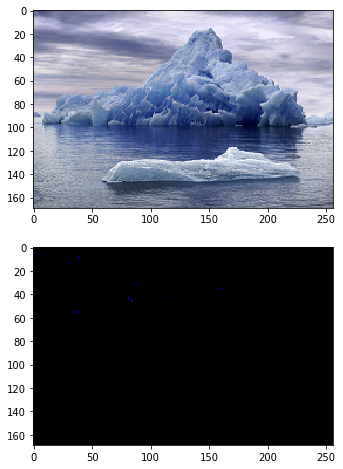

In [12]:
steg_img = lsb_blocks_encoder(img_tamplate.format(1), read_text(text_file))
steg_img.save('images/steg1.bmp')

f,ax = plt.subplots(2, figsize=(8, 8))
ax[0].imshow(steg_img)
ax[1].imshow(np_2_image(steg_img - open_image_2_np(img_tamplate.format(1))))
plt.show()

In [13]:
print('PLAINTEXT: ' + lsb_blocks_decoder('images/steg1.bmp'))
%timeit lsb_blocks_decoder('images/steg1.bmp')

PLAINTEXT: Maxim
41.6 ms ± 6.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Задание №2 - Метод квантования

In [14]:
def gen_table_key():
    val = np.arange(-255, 256)
    rand = np.random.randint(2, size=len(val))
    return dict(zip(val, rand))

In [15]:
def q_encoder(image, message, key):
    container = open_image_2_np(image)
    width, height, pix = container.shape
    result = np.copy(container)
    secret_message = str_2_bin(message, eol)
    ptr = 0
    
    for i in range(len(container)):
        delta = container[i, 0][0] - container[i, 1][0]
        if ptr == len(secret_message):
            break
        if int(secret_message[ptr]) == key[delta]:
            result[i, 0][0] = container[i, 0][0]
        else:
            n, m = -1, 1
            rv = 0
            while delta + m in key:
                if int(secret_message[ptr]) == key[delta + m]:
                    rv = m
                    break
                if int(secret_message[ptr]) != key[delta + m]:
                    m += 1
            else:
                while delta + n in key:
                    if int(secret_message[ptr]) == key[delta + n]:
                        rv = n
                        break
                    if int(secret_message[ptr]) != key[delta + n]:
                        n -= 1

            result[i, 0][0] = container[i, 0][0] + delta + rv - delta
        ptr += 1
    return np_2_image(result)

In [16]:
def q_decoder(image, key):
    container = open_image_2_np(image)
    res = []
    for i in range(len(container)):
        delta = container[i, 0][0] - container[i, 1][0]
        res.append(str(key[delta]))
    res = bin_2_str(''.join([b for b in res]))
    return res[:res.rfind(eol)]

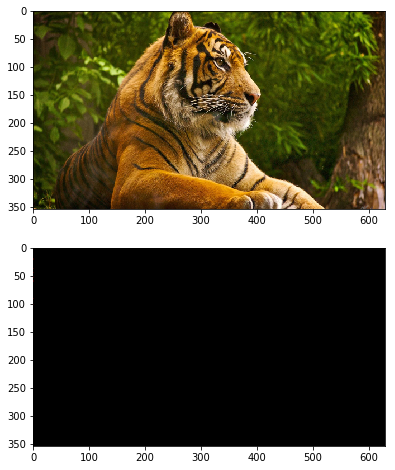

In [17]:
key = gen_table_key()
steg_img = q_encoder(img_tamplate.format(2), 'Max Krivich', key)
steg_img.save('images/steg2.bmp')

f,ax = plt.subplots(2, figsize=(8, 8))
ax[0].imshow(steg_img)
ax[1].imshow(np_2_image(steg_img - open_image_2_np(img_tamplate.format(2))))
plt.show()

In [18]:
print('PLAINTEXT: ' + q_decoder('images/steg2.bmp', key))
%timeit q_decoder('images/steg2.bmp', key)

PLAINTEXT: Max Krivich
6.3 ms ± 805 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Задание №3 - Метод Куттера-Джордана-Боссена (метод «креста»)

In [19]:
c_lambda = 0.05
pixel_brightness = lambda r, g, b: 0.29890*r + 0.58662*g + 0.11448*b
sigma = 3

In [20]:
def cross_encode(image, message, is_bin=False):
    container = open_image_2_np(image)
    width, height, pix = container.shape
    result = np.copy(container)
    if not is_bin:
        secret_message = str_2_bin(message, eol)
    else:
        secret_message = message
    ptr = 0
    
    for i in range(sigma, len(container) - sigma):
        if ptr == len(secret_message):
            break
        b = round(container[i, i][2] + (2*int(secret_message[ptr])-1)* \
                                            sigma*c_lambda*pixel_brightness(*container[i, i]))
        if 0 <= b <= 255:
            result[i,i,2] = b
        elif b > 255:
            result[i,i,2] = 255
        else:
            result[i,i,2] = 0
        ptr += 1
    return np_2_image(result)

In [21]:
def cross_decode(image, is_bin=False):
    container = open_image_2_np(image)
    res = []
    for i in range(sigma, len(container) - sigma):
        b = np.sum([container[i, j][2] for j in range(i-sigma, i)],  dtype=np.float) + \
            np.sum([container[j, i][2] for j in range(i-sigma, i)], dtype=np.float) + \
            np.sum([container[i, j][2] for j in range(i+1, i+sigma)], dtype=np.float) + \
            np.sum([container[j, i][2] for j in range(i+1, i+sigma)], dtype=np.float)
        b /= 4 * sigma
        if b < container[i, i][2]:
            res.append('1')
        if b > container[i, i][2]:
            res.append('0')
    if not is_bin:
        res = bin_2_str(''.join([b for b in res]))
        return res[:res.rfind(eol)]
    else:
        return ''.join([b for b in res])

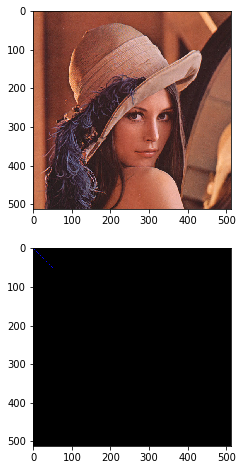

In [22]:
steg_img = cross_encode(img_tamplate.format(3), 'test')
steg_img.save('images/steg3.bmp')

f,ax = plt.subplots(2, figsize=(8, 8))
ax[0].imshow(steg_img)
ax[1].imshow(np_2_image(steg_img - open_image_2_np(img_tamplate.format(3))))
plt.show()

In [23]:
print('PLAINTEXT: ' + cross_decode('images/steg3.bmp'))
%timeit cross_decode('images/steg3.bmp')

PLAINTEXT: tesw4$ÿÿÿÿÿÿ·ÿÿßÿ÷ÿûÿÿÿïÿÿÜ^äßÿßþ?ïÿÿÿÿÿÏÿ÷ÿÝÿ÷ïþÿÿÿÿÿÿÿÿÿuÿÿ
64.8 ms ± 5.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Задание 4. Исследование вероятностных характеристик стенографического метода встраивания данных Куттера-Джордана-Боссена (метода «креста»)

In [24]:
%time
V = []
Vx = []
W = []
for la in np.arange(0.01, 0.46, 0.05, dtype=np.float64):
    c_lambda = la
    msg = 'test' * 5
    steg_img = cross_encode(img_tamplate.format(3), msg)
    steg_img.save('images/steg3.bmp')
    res = str_2_bin(cross_decode('images/steg3.bmp'))
    bmsg = str_2_bin(msg)
    v = 0
    
    for i in range(len(bmsg)):
        if res[i] == bmsg[i]:
            v += 1
    V.append(np.float64(v / len(bmsg)))
    Vx.append(la)
    
    w = 0
    con1 = open_image_2_np('images/img3.bmp')
    con2 = open_image_2_np('images/steg3.bmp')
    for i in range(sigma, len(con1) - sigma):
        w = w + abs(con2[i,i,2] - con1[i,i,2])
    W.append((w * 100) / (len(bmsg) * 256))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


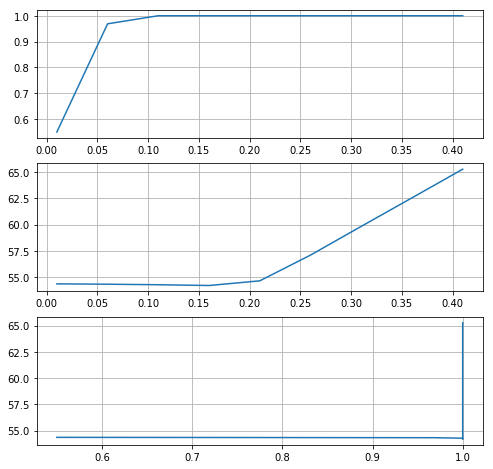

In [25]:
f,ax = plt.subplots(3, figsize=(8,8))
ax[0].plot(Vx, V)
ax[0].grid()
ax[1].plot(Vx, W)
ax[1].grid()
ax[2].plot(V, W)
ax[2].grid()
plt.show()